In [1]:
import json
import os
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus   import stopwords

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import collections
import wordcloud as wc


from collections import defaultdict
from bisect import bisect_left

In [3]:
#set json format in readable form (starting wih multiple objec format, need list)
annotation_dir='D:/Users/sarab/work/enviroLens/files/'
print('Loading annotations')
annotations=[]
for filename in os.listdir(annotation_dir):
    print('loading file ',filename)
    lines = [line.rstrip('\n') for line in open(annotation_dir+filename,encoding='utf-8')]
    for line in lines:
        js=json.loads(line)
        annotations.append(js)


Loading annotations
loading file  annotated_docs_0.jsonl
loading file  annotated_docs_1.jsonl
loading file  annotated_docs_2.jsonl
loading file  annotated_docs_3.jsonl
loading file  annotated_docs_4.jsonl


In [4]:
# number of documents
nb_docs = len(annotations)
print(nb_docs)


72154


### TEXT ANALYSIS

In [5]:
# load all text 
corpus = [ ]
for k in range(len(annotations)):
    text = annotations[k]["text"]
    corpus.append(text)

one_text ="".join(corpus)

In [210]:
# import natural language toolkit

# prepare stopword list
stop_words = stopwords.words('english')

def removeStopwords(dictionary, stopwords):
    """removes stopwords from dictionary with word keyes"""
    filtered_dict = {}
    for k, v in dictionary.items():
        if not k in stopwords:
            filtered_dict[k] = v 
    return filtered_dict

#check if number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

#chec if text that is already filtere with is_number consisits only of letters, but can have multiple words
def without_numbers(s):
    # split the string into an array of words
    words = s.split()
    # iterate through the words
    for word in words:
        if not word.isalpha():
            # the word consists non-alpha values
            return False
    # all words are alpha values
    return True
        
    

In [221]:
# count frequences of words
cv = CountVectorizer(stop_words = "english") 
cv_fit=cv.fit_transform(corpus)  
word_list = cv.get_feature_names() 
count_list = cv_fit.sum(axis=0)
count_list.shape
count_list=count_list.tolist()[0]
counted_words=np.stack((np.array(word_list),np.array(count_list)),axis=-1)


In [222]:
# filtering from those that have numbers, and converting the frequency variable to integer
counted_words=[[item[0],int(item[1])] for item in counted_words if not is_number(item[0])]

# sort based on the frequency, in descending order
counted_words=sorted(counted_words,key=lambda x: x[1],reverse=True)


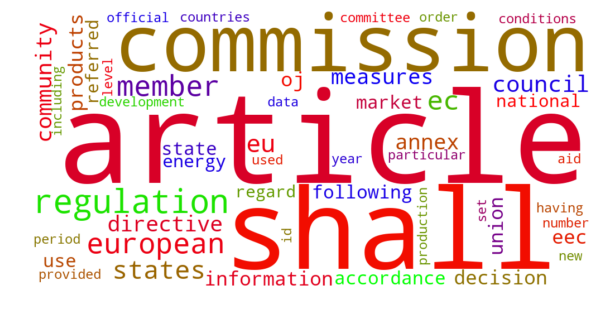

In [223]:
#most common words
common_words = dict(counted_words[0:200])
plt.rcParams['figure.figsize'] = [10, 8]
word_cl = wc.WordCloud(colormap ='brg', width= 1000, height=500, max_words=50,relative_scaling=0.5,normalize_plurals=False,background_color="white").generate_from_frequencies(common_words)
plt.axis("off")
plt.imshow(word_cl,interpolation='bilinear')
    

In [224]:
# most importatnt words by TFIDF
vectorizer = TfidfVectorizer(stop_words = "english") 
vectors = vectorizer.fit_transform(corpus)

# sum all vectors to get tfidf for all documents together
one_vector = np.sum(vectors, axis=0)
one_vector = one_vector.tolist()
[one] = one_vector
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(one, index=vectorizer.get_feature_names(), columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)

#converting the frequency variable to integer
df = df["tfidf"].astype(float)

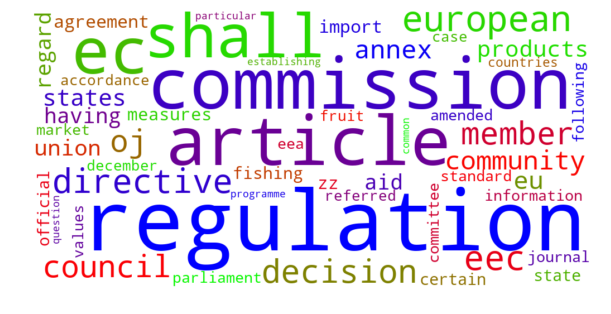

In [225]:
# get words with highest tfidf 
common_words = dict(df[0:200])

# filtering from those that have numbers 
delete = [key for key in common_words if is_number(key)]  
for key in delete: 
        del common_words[key] 

plt.rcParams['figure.figsize'] = [10, 8]
word_cl = wc.WordCloud(colormap ='brg',width= 1000, height=500, max_words=50,relative_scaling=0.5,normalize_plurals=False,background_color="white").generate_from_frequencies(common_words)
plt.axis("off")
plt.imshow(word_cl,interpolation='bilinear')

In [226]:
# calculate idf
counted_words = dict(counted_words)
#print(counted_words)
tfidf = dict(df)
idf = {}
for k,v in counted_words.items():
    tfidf_value = tfidf.get(k)
    idf[k] = tfidf_value/v

idf = sorted(idf.items(), key=lambda x: x[1]) 

### WIKIFIER ANNOTATIONS
 words and phrases that represent something meaningful on Wikipedia page 

In [228]:
#one list of all annotations
onelist = []
for k in range(len(annotations)):
    annot = annotations[k]["annotations"]['wiki']
    for i in annot:
        onelist.append(i["name"])
onelist = [w.lower() for w in onelist ]

In [229]:
#counting number of occurances for wiki annotations
counter=collections.Counter(onelist)

#most common annotations
common_words = counter.most_common(22)

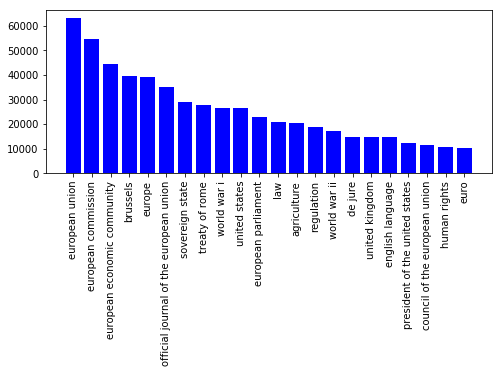

In [230]:
#20 most frequent wiki annotations
word = []
frequency = []
for i in range(len(common_words)): 
    word.append(common_words[i][0])
    frequency.append(common_words[i][1])

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 3]
indices = np.arange(len(common_words))
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.show()


In [231]:

#tole se spremeni, ko se spremenijo podatki ???????? kako bo to slo??
print("How many anotations are there?")
print(len(counter.keys()))


print("How many has occurance less than 10000?")
annot_with_occ1 = [k for k,v in counter.items() if v < 10000]
print(len(annot_with_occ1))

print("How many has occurance 1, 2, 3?")
annot_with_occ1 = [k for k,v in counter.items() if v == 1]
print(len(annot_with_occ1))
annot_with_occ2 = [k for k,v in counter.items() if v == 2]
print(len(annot_with_occ2))
annot_with_occ3 = [k for k,v in counter.items() if v == 3]
print(len(annot_with_occ3))

print("number of occurances for 22 most common")
print(counter.most_common(22))

How many anotations are there?
157246
How many has occurance less than 10000?
157224
How many has occurance 1, 2, 3?
62982
23000
12491
number of occurances for 22 most common
[('european union', 63033), ('european commission', 54361), ('european economic community', 44219), ('brussels', 39734), ('europe', 39192), ('official journal of the european union', 35227), ('sovereign state', 29115), ('treaty of rome', 27908), ('world war i', 26737), ('united states', 26672), ('european parliament', 22785), ('law', 20755), ('agriculture', 20493), ('regulation', 18763), ('world war ii', 17294), ('de jure', 14901), ('united kingdom', 14871), ('english language', 14716), ('president of the united states', 12195), ('council of the european union', 11594), ('human rights', 10836), ('euro', 10273)]


In [232]:
#number of wiki concepts detected per document:
nb_wikiconcepts = []
for k in range(len(annotations)):
    annot = annotations[k]["annotations"]['wiki']
    nb_wikiconcepts.append(len(annot))
#print(nb_wikiconcepts)

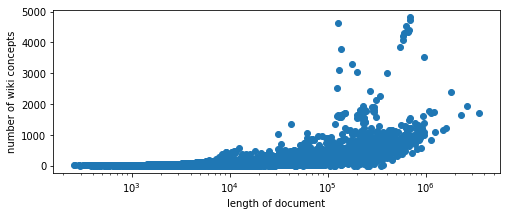

In [233]:
# list of lengths of docs
lengths_of_docs = []
for txt in corpus:
    lengths_of_docs.append(len(txt))


#correlation between length of documents and number of wiki concepts
# x scale logarithmic 
plt.xlabel('length of document')
plt.ylabel('number of wiki concepts')
plt.rcParams['figure.figsize'] = [8, 4]
plt.xscale('log')
plt.scatter(lengths_of_docs, nb_wikiconcepts)


### NAMED ENTITIES
Names of words or classes of words that represent someone/something/someplace. Most important classes are person category, organization category and location category.

In [234]:
# lists of text and types
onelistNEText =[]
onelistNEType =[]
types_per_doc = []
for k in range(len(annotations)):
    doc_types = []
    NE = annotations[k]["annotations"]["NE"]
    for i in NE:
        onelistNEText.append(i["text"])
        onelistNEType.append(i["type"])
        doc_types.append(i["type"])
    types_per_doc.append(doc_types)
print(len(onelistNEText))
print(len(onelistNEType))


18305314
18305314


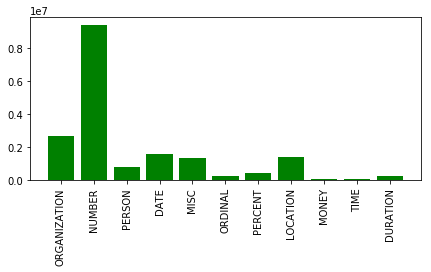

In [235]:
# type frequences for all documents together
countType=collections.Counter(onelistNEType)


#%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 3]
plt.bar(countType.keys(), countType.values(), color='g')
plt.xticks(rotation='vertical')
#plt.title("type frequences for all documents together")
plt.show()

In [236]:
# type frequences for classes PERSON, LOCATION, ORGANIZATION for each document
types_per_doc_PLC =[]
delete = [key for key in countType if key not in ['ORGANIZATION','PERSON','LOCATION']]
for doc in types_per_doc:
    counted = collections.Counter(doc)
   
    for key in delete: 
              del counted[key]
    types_per_doc_PLC.append(counted)
    
#print(types_per_doc_PLC)


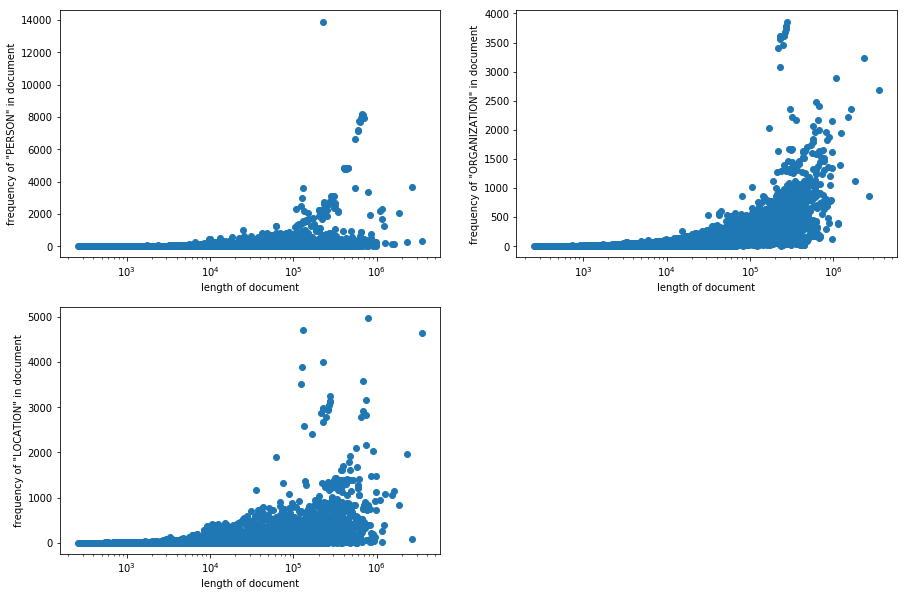

In [237]:
#correlation between length of documents and PERSON, LOCATION or ORGANIZATION frequncy
# x scale logarithmic 
prsn_frq = []
org_frq = []
loc_frq =[]
for doc in types_per_doc_PLC:
    prsn = doc.get("PERSON", 0)
    prsn_frq.append(prsn)
    org = doc.get("ORGANIZATION", 0)
    org_frq.append(org)
    loc = doc.get("LOCATION", 0)
    loc_frq.append(loc)

#plot scatter grphs
# Create 2x2 sub plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
gs = gridspec.GridSpec(2, 2)

pl.figure()
ax = pl.subplot(gs[0, 0]) # row 0, col 0
ax.set_xlabel('length of document')
ax.set_ylabel('frequency of "PERSON" in document')
ax.set_xscale('log')
plt.scatter(lengths_of_docs, prsn_frq)

ax = pl.subplot(gs[0, 1]) # row 0, col 1
ax.set_xlabel('length of document')
ax.set_ylabel('frequency of "ORGANIZATION" in document')
ax.set_xscale('log')
plt.scatter(lengths_of_docs, org_frq)

ax = pl.subplot(gs[1, 0])
ax.set_xlabel('length of document')
ax.set_ylabel('frequency of "LOCATION" in document')
ax.set_xscale('log')
plt.scatter(lengths_of_docs, loc_frq)


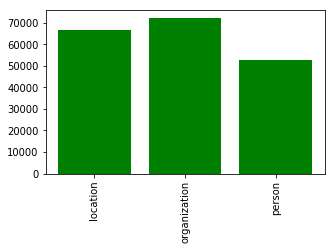

In [238]:
# in how many documents appears entity PERSON, LOCATION or ORGANIZATION 
nb_docs_person =0
nb_docs_organization=0
nb_docs_location=0
for doc in types_per_doc:
    if "PERSON" in doc:
        nb_docs_person = nb_docs_person + 1
    if "ORGANIZATION" in doc:
        nb_docs_organization = nb_docs_organization + 1
    if "LOCATION" in doc:
        nb_docs_location = nb_docs_location + 1
        
plt.rcParams['figure.figsize'] = [5, 3]       
x = [nb_docs_location,nb_docs_organization, nb_docs_person]
plt.bar(["location","organization", "person"], x, color='g')
plt.xticks(rotation='vertical')
#plt.title("number of documents in wich appears entity")
plt.show()

In [267]:
# get lists of words/NEtext that are of the type location, perso, org and misc
names_loc =[]
names_org =[]
names_prs =[]
names_MISC = []
names_nmb = []
for k in range(len(annotations)):
    NE = annotations[k]["annotations"]["NE"]
    for i in NE:
        if i["type"]== "LOCATION":
            names_loc.append(i["text"])
        elif i["type"]== "ORGANIZATION":
            names_org.append(i["text"])
        elif i["type"]== "PERSON":
            names_prs.append(i["text"])
        elif i["type"]== "MISC":
            names_MISC.append(i["text"])
        elif i["type"]== "NUMBER":
            names_nmb.append(i["text"])
            
        



In [240]:
# what contains class MISC
print(names_MISC[0:100])

['Council Regulation', 'Regulation', 'Regulation', 'Finnish', 'Swedish', 'Regulation', 'EUROPEAN', 'Council Regulation', 'Regulation', 'No 2069/92', 'Commission Regulation', 'Regulation', 'Whereas Commission Regulation', 'Regulation', 'No 1258/91', 'Regulation', 'No 3446/90', 'Commission Regulation', 'No 2592/92', 'Regulation', 'No 3446/90', 'Regulation', 'Regulation', 'No 2592/92', 'EUROPEAN', 'EUROPEAN ECONOMIC', 'EUROPEAN INVESTMENT BANK Third Report', 'EurObserv`ER', 'Eurobserv`Er', 'French', 'Regulation', 'European', 'Basque', 'French', 'French', 'Eastern', 'French', 'French', 'French', 'French', 'Kyoto Protocol', 'EU-28', 'Communication on Alternative Fuels Action Plans', 'National Adaptation Strategy', 'National Adaptation Plan', 'European', 'EU-average', 'EUR', 'EUR', 'Finance Act', 'Energy Transition Act', 'French', 'NREAP', 'European', 'European', 'Energy Transition Act', 'French', 'Mission Innovation', 'Multi-scale', 'French', 'French', 'EUR', 'EUR', 'European', '``Eastern A

In [268]:
# number of different named entity words in number class
print(len(collections.Counter(names_nmb)))
names_nmb = [w.lower() for w in names_nmb]
print(len(collections.Counter(names_nmb)))

599628
599224


In [241]:
# number of different word/text names for classes loc, org and pers 
count_loc=collections.Counter(names_loc)
print("locations: number of different locations and top 10")
# delete = [key for key in count_loc if is_number(key)]  
# for key in delete: 
#     del count_loc[key] 
print(len(count_loc))
print(count_loc.most_common(10))

print("organizations:number of different organizations and top 10")
count_org=collections.Counter(names_org)
# delete = [key for key in count_org if is_number(key)]   
# for key in delete: 
#     del count_org[key] 
print(len(count_org))
print(count_org.most_common(10))

print("persons:number of different pesons and top 10")
count_prs=collections.Counter(names_prs)
# delete = [key for key in count_prs if is_number(key)]   
# for key in delete: 
#     del count_prs[key] 
print(len(count_prs))
print(count_prs.most_common(10))

locations: number of different locations and top 10
60362
[('EU', 52676), ('Brussels', 50665), ('Europe', 40202), ('Germany', 34159), ('France', 34015), ('Spain', 30332), ('Italy', 25416), ('United Kingdom', 24724), ('Portugal', 21175), ('Netherlands', 18959)]
organizations:number of different organizations and top 10
125006
[('Commission', 408795), ('EC', 323753), ('EU', 261473), ('EEC', 116490), ('European Parliament', 97314), ('OJ', 85702), ('Council', 71337), ('European Union', 71132), ('European Community', 38521), ('Committee', 33186)]
persons:number of different pesons and top 10
146302
[('his', 12636), ('he', 6068), ('Reg', 4631), ('Carc', 4159), ('EFSA', 3808), ('Muta', 2981), ('Fischler', 2028), ('him', 1905), ('José Manuel BARROSO', 1724), ('her', 1652)]


In [242]:
least_common_words = count_loc.most_common()[:-9-1:-1]
print(least_common_words)

[('Royal Netherlands', 1), ('UK Slovakia', 1), ('Netherlands Malta', 1), ('France Bulgaria', 1), ('Estonia Portugal', 1), ('Denmark Greece', 1), ('Lambarene', 1), ('Sedekopan', 1), ('Etizola', 1)]


number of all named entities
1082857
number of all named entities
985484


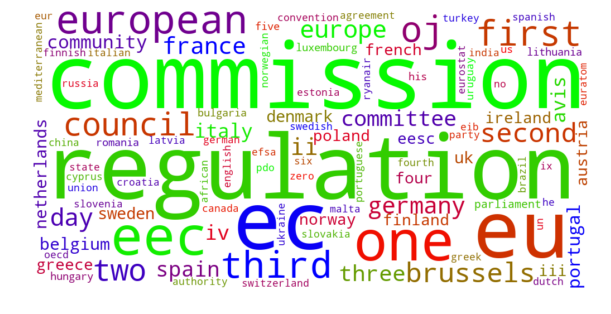

In [243]:
# most common word entities
# lower cases
onelistNEText = [w.lower() for w in onelistNEText]
countText=collections.Counter(onelistNEText)
print("number of all named entities")
print(len(countText))

# keep only words that are not numbers but can be numbers+str
delete = [key for key in countText if is_number(key)]   
for key in delete: 
    del countText[key] 

#number of all named entities
print("number of all named entities")
print(len(countText))
common_words = countText.most_common(200)
for tup in common_words:
    if len(tup[0])== 1:
        common_words.remove(tup)

common_words = dict(common_words)
#delete all 
delete = [key for key in common_words if not key.isalpha()]   
for key in delete: 
    del common_words[key] 
plt.rcParams['figure.figsize'] = [10, 8]
word_cl = wc.WordCloud(colormap ="brg" ,width= 1000, height=500, max_words=100,relative_scaling=0.5,normalize_plurals=False,background_color="white").generate_from_frequencies(common_words)
plt.axis("off")
plt.imshow(word_cl,interpolation='bilinear')



### ANNOTATED WORDS
Set of annotations extracted on the word level, we were specifically interested in word norms – normal forms of the words 

In [244]:
# lists of norms

onelistaWnorm = []

for k in range(len(annotations)):
    aW = annotations[k]["annotations"]["annotatedWords"]["words"]
    for i in aW:
        onelistaWnorm.append(i["norm"])


In [269]:
# lower cases
onelistaWnorm = [w.lower() for w in onelistaWnorm ]
counter=collections.Counter(onelistaWnorm)

#most common annotations
common_words = counter.most_common(150)

#remove stop words
clean_occurances_aWnorm = removeStopwords(counter, stop_words)

#keep only words that consist of letters
delete = [key for key in clean_occurances_aWnorm if is_number(key)]  
for key in delete: 
    del clean_occurances_aWnorm[key] 
delete = [key for key in clean_occurances_aWnorm if not without_numbers(key)]  
for key in delete: 
    del clean_occurances_aWnorm[key]

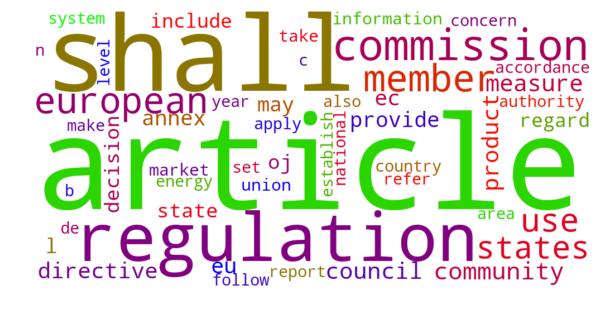

In [270]:
    
# sort descending
clean_occurances_aWnorm = sorted(clean_occurances_aWnorm.items(), key=lambda x: x[1])
clean_occurances_aWnorm = clean_occurances_aWnorm[::-1]

top_clean_occurances_aWnorm = clean_occurances_aWnorm[0:100]


#plot most common annotated words (norms of words)

delete = [key for key in top_clean_occurances_aWnorm if len(key) == 1]  
for key in delete: del top_clean_occurances_aWnorm[key]   
top_clean_occurances_aWnorm = dict(top_clean_occurances_aWnorm)

plt.rcParams['figure.figsize'] = [10, 8]
word_cl = wc.WordCloud(colormap ="brg", width= 1000, height=500, max_words=50,relative_scaling=0.5,normalize_plurals=False,background_color="white").generate_from_frequencies(top_clean_occurances_aWnorm)
plt.axis("off")
plt.imshow(word_cl,interpolation='bilinear')

### ONTOLOGIES

In [247]:
# dictionaries of wiki_dataClasses, wordAnnot_norms, wordAnnot_synonyms
onelistWiki_name = {}
onelistWiki_dataClasses = {}
onelistNE_name = {}
onelistNE_syn = {}
onelistWordAnnot_norm = {}
onelistWordAnnot_syn = {}

# also ontologies for each doc
docs_wn = []
docs_wdc = []
docs_NEn = []
docs_NEs = []
docs_WAn = []
docs_WAs = []

for k in range(len(annotations)): 
    ont_terms = annotations[k]["annotations"]["ontology_terms"]
    y1 = ont_terms["wiki-name"]
    y2 = ont_terms["wiki-WikiDataClasses"]
    y3 = ont_terms["NE-name"]
    y4 = ont_terms["NE-syn"]
    y5 = ont_terms["wordAnnot-norm"]
    y6 = ont_terms["wordAnnot-syn"]
    onelistWiki_name = { k: onelistWiki_name.get(k, 0) + y1.get(k, 0) for k in set(onelistWiki_name) | set(y1) }
    onelistWiki_dataClasses = { k: onelistWiki_dataClasses.get(k, 0) + y2.get(k, 0) for k in set(onelistWiki_dataClasses) | set(y2) }
    onelistNE_name = { k: onelistNE_name.get(k, 0) + y3.get(k, 0) for k in set(onelistNE_name) | set(y3) }
    onelistNE_syn = { k: onelistNE_syn.get(k, 0) + y4.get(k, 0) for k in set(onelistNE_syn) | set(y4) }
    onelistWordAnnot_norm = { k: onelistWordAnnot_norm.get(k, 0) + y5.get(k, 0) for k in set(onelistWordAnnot_norm) | set(y5) }
    onelistWordAnnot_syn = { k: onelistWordAnnot_syn.get(k, 0) + y6.get(k, 0) for k in set(onelistWordAnnot_syn) | set(y6) }
 
    docs_wn.append(y1)
    docs_wdc.append(y2)
    docs_NEn.append(y3)
    docs_NEs.append(y4)
    docs_WAn.append(y5)
    docs_WAs.append(y6)

# print("onelistWiki_name")
# print(onelistWiki_name)
# print("onelistWiki_dataClasses")
# print(onelistWiki_dataClasses)
# print("onelistNE_name")
# print(onelistNE_name)
# print("onelistNE_syn")
# print(onelistNE_syn)
# print("onelistWordAnnot_norm")
# print(onelistWordAnnot_norm)
# print("onelistWordAnnot_syn")
# print(onelistWordAnnot_syn)




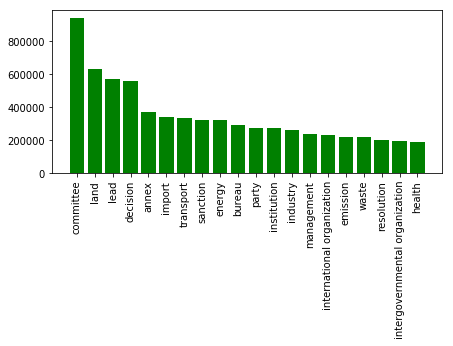

In [248]:
#aggregation of all the classes of mapped ontologies, top 20
allOT = [onelistWiki_name, onelistWiki_dataClasses, onelistNE_name ,onelistNE_syn,onelistWordAnnot_norm,onelistWordAnnot_syn]
merged_OT ={}
for i in range(len(allOT)):
    merged_OT = { k: merged_OT.get(k, 0) + allOT[i].get(k, 0) for k in set(merged_OT) | set(allOT[i]) }

merged_OT = sorted(merged_OT.items(), key=lambda x: x[1])
merged_OT = merged_OT[::-1]
merged_OT = dict(merged_OT[0:20])
plt.rcParams['figure.figsize'] = [7, 3]
plt.bar(merged_OT.keys(), merged_OT.values(), color='g')
plt.xticks(rotation='vertical')
plt.show()

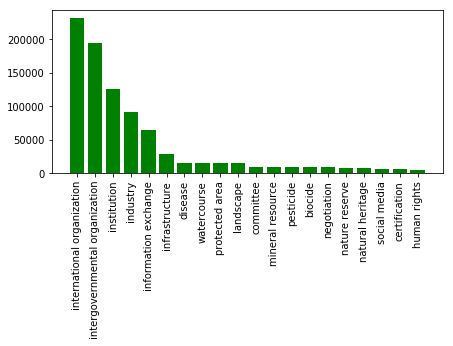

In [249]:
#number of occurances for Wiki_dataClasses, top 20

onelistWiki_dataClasses = sorted(onelistWiki_dataClasses.items(), key=lambda x: x[1])
onelistWiki_dataClasses = onelistWiki_dataClasses[::-1]
onelistWiki_dataClasses = dict(onelistWiki_dataClasses[0:20])
plt.rcParams['figure.figsize'] = [7, 3]
plt.bar(onelistWiki_dataClasses.keys(), onelistWiki_dataClasses.values(), color='g')
plt.xticks(rotation='vertical')
plt.show()

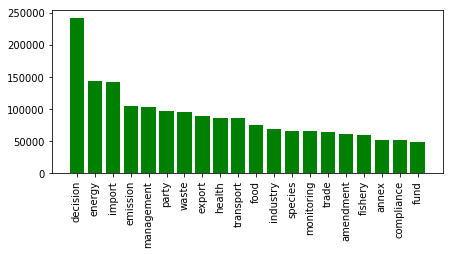

In [250]:
#number of occurances for WordAnnot_norm, top 20
onelistWordAnnot_norm = sorted(onelistWordAnnot_norm.items(), key=lambda x: x[1])
onelistWordAnnot_norm = onelistWordAnnot_norm[::-1]
onelistWordAnnot_norm = dict(onelistWordAnnot_norm[0:20])
plt.rcParams['figure.figsize'] = [7, 3]
plt.bar(onelistWordAnnot_norm.keys(), onelistWordAnnot_norm.values(), color='g')
plt.xticks(rotation='vertical')
plt.show()

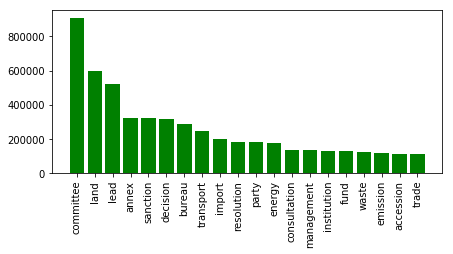

In [251]:
#number of occurances for WordAnnot_syns
onelistWordAnnot_syn = sorted(onelistWordAnnot_syn.items(), key=lambda x: x[1])
onelistWordAnnot_syn = onelistWordAnnot_syn[::-1]
onelistWordAnnot_syn = dict(onelistWordAnnot_syn[0:20])
plt.rcParams['figure.figsize'] = [7, 3]
plt.bar(onelistWordAnnot_syn.keys(), onelistWordAnnot_syn.values(), color='g')
plt.xticks(rotation='vertical')
plt.show()

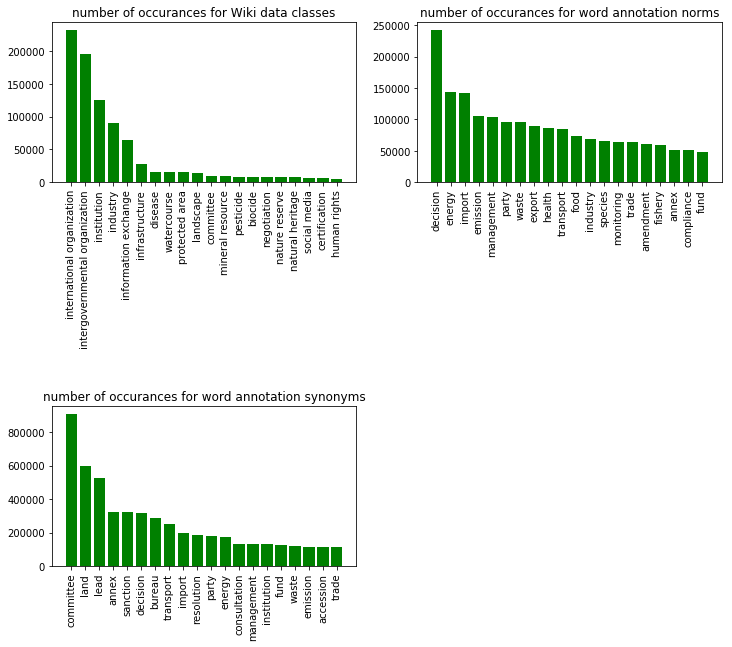

In [252]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
gs = gridspec.GridSpec(3, 2)

pl.figure()
ax = pl.subplot(gs[0, 0]) # row 0, col 0
ax.set_title('number of occurances for Wiki data classes')
plt.bar(onelistWiki_dataClasses.keys(), onelistWiki_dataClasses.values(), color='g')
plt.xticks(rotation='vertical')

#number of occurances for WordAnnot_norm, top 20
ax = pl.subplot(gs[0, 1]) # row 0, col 0
ax.set_title('number of occurances for word annotation norms')
plt.bar(onelistWordAnnot_norm.keys(), onelistWordAnnot_norm.values(), color='g')
plt.xticks(rotation='vertical')

#number of occurances for WordAnnot_syns

ax = pl.subplot(gs[2, 0]) # row 0, col 0
ax.set_title('number of occurances for word annotation synonyms')
plt.bar(onelistWordAnnot_syn.keys(), onelistWordAnnot_syn.values(), color='g')
plt.xticks(rotation='vertical')
plt.show()

In [253]:
#DOCS TO ONTOLOGY
#for each document 3 most frequent ontology terms for each of 6 categories of mapped ontologies
documents = []
for i in range(nb_docs):
    document = []
    for type in [docs_wdc,docs_WAn,docs_WAs]:
        if len(type[i])==0:
            top = []
        elif len(type[i])<4:
            #rewrite them as list
            top = [(k, v) for k, v in type[i].items()]
        else:
            k = collections.Counter(type[i])
            top = k.most_common(3)
        document.append(top)
    documents.append(document)

print(documents[0:1])


[[[('international organization', 3), ('intergovernmental organization', 2), ('institution', 2)], [('import', 9), ('licence', 6), ('party', 1)], [('import', 11), ('licence', 6), ('committee', 4)]]]


In [254]:
# for each document 3 most frequent ontology terms from all 6 categories aggregated
documents_agrg =[]
for i in range(nb_docs):
    doc = {}
    for type in [docs_wn,docs_wdc,docs_NEn,docs_NEs,docs_WAn,docs_WAs]:
        doc = { k: doc.get(k, 0) + type[i].get(k, 0) for k in set(doc) | set(type[i]) }
    documents_agrg.append(doc)

documents_agrg_top = []
for doc in documents_agrg:
    documents_agrg_top.append(collections.Counter(doc).most_common(3))

        